In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../..")
from utils import *

In [4]:
path = Path('F:/genome/mammals/')

In [5]:
tok = Tokenizer(GenomicTokenizer, n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [6]:
df_valid = pd.read_csv(path/'mammal_val.csv')

In [7]:
df_iter = pd.read_csv(path/'mammal_train.csv', chunksize=1000000)

In [8]:
df = next(df_iter)

In [9]:
df.head()

,Sequence,Source,set
0,TAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAACCCTAAC...,NCBI Human,train
1,CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGG...,NCBI Human,train
2,ACCTGCCCCACAGCCTTGCCTGGATTTCTATCTCCCTGGCTTGGTG...,NCBI Human,train
3,CTGGGGAAGCTTACTGTGTCCAAGAGCCTGCTGGGAGGGAAGTCAC...,NCBI Human,train
4,TGAAGATGGAGCCATATTCCTGCAGGCGCCCTGGAGCAGGGTACTT...,NCBI Human,train


# Part 1
0-200,000

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, 
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
data.train_ds[0]

In [12]:
np.save(path/'mammal_vocab.npy', data.vocab.itos)

In [10]:
voc = np.load(path/'mammal_vocab.npy')
model_vocab = GenomicVocab(voc)

In [12]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [11]:
len(model_vocab.stoi), len(model_vocab.itos)

(1025, 1025)

In [15]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult = 0.25

In [16]:
learn = get_model_LM(data, drop_mult, config)

In [ ]:
learn.data.train_ds[0]

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03


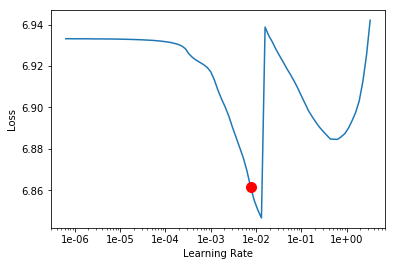

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.370264,2.372840,0.233079


# Part 2
200,000-400,000

In [24]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [25]:
learn.data = data

In [26]:
learn.data.train_ds[0]

(Text TTCAT CATAC TACCA CCATT ATTCA TCAAA AAAAT AATTC TTCAG CAGAA GAAGG AGGTA GTACC ACCAA CAAAG AAGAA GAATA ATATA ATACA ACAGT AGTGG TGGAA GAAAG AAGTC GTCTT CTTCC TCCTC CTCCT CCTAC TACTT CTTCT TCTGT TGTTC TTCCC CCCAA CAATC ATCAC CACTC CTCAA CAATT ATTAC TACCC CCCAC CACCC CCCCA CCAGA AGAGG AGGCA GCAAT AATCG TCGAT GATTT TTTCT TCTTA TTATG ATGTA GTATC ATCCT CCTTC TTCTA CTAGA AGAGA AGATG ATGTT GTTTT TTTAT TATCC TCCAT CATAA TAAAC AACAA CAAGT AGTAA TAAAT AATTA TTATA ATATA ATATA ATATA ATAAT AATGT TGTTA TTAAT AATAT TATAT TATAT TATAC TACAT CATCC TCCAA CAAAT AATAT TATAT TATGT TGTGT TGTGT TGTAT TATAT TATAT TATGA TGAAA AAATT ATTCT TCTTA TTACC ACCAT CATTT TTTCT TCTTT TTTTT TTTAT TATAT TATAA TAAAT AATGA TGATA ATAGC AGCAT CATAC TACTA CTATT ATTTA TTATA ATACC ACCGT CGTCC TCCTA CTATA ATACA ACATC ATCTT CTTGC TGCTT CTTTT TTTGT TGTCG TCGAA GAATT ATTCA TCAGT AGTCC TCCTT CTTTT TTTGA TGAAA AAAAG AAGAA GAAAT AATTT TTTAG TAGCA GCAAT AATAT TATAT TATAG TAGGT GGTAC TACAT CATAC TACAC CACAC CACAA CAAGT AGTAT TATAC TACA

In [27]:
lr = 1e-2/1.35

In [28]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.332373,2.310076,0.255104


In [29]:
learn.save('mammal_in_training')

# Part 3

400,000-700,000

In [30]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [31]:
learn.data = data

In [32]:
learn.data.train_ds[0]

(Text AGAGA AGATA ATACT ACTAA TAATA ATATA ATATT ATTTT TTTTA TTAAT AATTG TTGTT GTTTT TTTAT TATAA TAAAT AATAA TAATC ATCTA CTACC ACCTT CTTTT TTTAT TATTT TTTTG TTGGG GGGGG GGGAG GAGGA GGAAA AAACA ACATC ATCCT CCTCA TCAAG AAGTG GTGTC GTCAG CAGGG GGGAG GAGTC GTCTC CTCAA CAAGC AGCTA CTAAG AAGAA GAAAA AAATA ATAGT AGTCT TCTTC TTCCA CCACC ACCCA CCAAC AACAT CATTT TTTCA TCAAA AAAGA AGAGG AGGCT GCTAC TACGA CGAGC AGCCA CCAAC AACTC CTCAT CATTT TTTTT TTTGG TGGGG GGGGA GGATA ATAGC AGCCA CCATA ATATT ATTCT TCTCA TCAGC AGCAG CAGGG GGGAA GAAAG AAGGG GGGGC GGCAA CAAGA AGACC ACCCT CCTTT TTTTC TTCCA CCAGG AGGTA GTAAG AAGAT GATTC TTCCT CCTCT TCTCT TCTTG TTGAG GAGAA GAACT ACTAA TAAGC AGCTT CTTCT TCTCT TCTTG TTGGC GGCCA CCACA ACAGG AGGTG GTGGG GGGTC GTCAG CAGTT GTTTA TTAGT AGTCA TCAGT AGTGA TGAGG AGGGT GGTCT TCTTA TTAGG AGGGC GGCTG CTGTA GTATT ATTTT TTTGT TGTTT TTTCC TCCTA CTACT ACTGT TGTTG TTGCT GCTGG TGGGT GGTTA TTAGT AGTAT TATGG TGGCT GCTAC TACCT CCTGC TGCCC CCCTA CTAGG AGGTC GTCCA CCAAC AACCT CCTGT TGTCC TCCC

In [33]:
lr = 1e-2/1.35**2

In [34]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.263601,2.244481,0.279138


In [35]:
learn.save('mammal_in_training')

# Part 4

700,000 - 1,000,000

In [36]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [37]:
learn.data = data

In [38]:
learn.data.train_ds[0]

(Text GGCTA CTAAA AAATT ATTGC TGCAA CAAGT AGTCC TCCAA CAATC ATCTA CTATT ATTTT TTTTC TTCTG CTGAT GATCT TCTTA TTATG ATGTG GTGTT GTTCA TCACC ACCTG CTGAA GAAAG AAGCA GCAAA AAAAT AATAA TAATG ATGAG GAGTT GTTCA TCAGA AGATA ATATT ATTCT TCTTG TTGCA GCATG ATGGA GGAAA AAACA ACATA ATACT ACTCA TCATT ATTGT TGTGA TGATC ATCAG CAGAA GAATG ATGAA GAAGG AGGAA GAAGT AGTTA TTATT ATTGC TGCTA CTAAT AATGC TGCAC CACTT CTTAC TACAA CAAAT AATAT TATGT TGTTT TTTAT TATCC TCCCT CCTGC TGCGA CGAGC AGCTA CTAAT AATGT TGTGT TGTCT TCTCA TCAAT AATTC TTCCT CCTGA TGAAA AAAGT AGTCA TCATT ATTAT TATTA TTACC ACCTT CTTGC TGCTC CTCCT CCTTT TTTCT TCTAG TAGTA GTATT ATTTT TTTAA TAAAA AAAGA AGATG ATGAA GAAAA AAAAG AAGTG GTGAT GATAA TAAAT AATTT TTTCA TCAAA AAAAT AATAA TAATA ATAAA AAAAC AACAT CATCA TCATT ATTAT TATTT TTTTT TTTGA TGACA ACATT ATTGA TGAGG AGGAT GATGT TGTCA TCATT ATTTT TTTGT TGTAA TAAAT AATTA TTAAC AACCT CCTAT TATGA TGACA ACATT ATTTT TTTTA TTACT ACTTT TTTTT TTTGG TGGTT GTTAA TAATC ATCCT CCTTC TTCAG CAGAT GATTT TTTAC TACTC CTCT

In [39]:
lr = 1e-2/1.35**3

In [40]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.244592,2.207216,0.293235


In [41]:
learn.save('mammal_in_training')

# Part 5

df 1,000,000 - 2,000,000

0-200,000

In [18]:
df = next(df_iter)

In [19]:
df.head()

,Sequence,Source,set
1000000,CATTGTTTTCATTCTCCATGACCGCTGTGGGTCACTTTCTATTATT...,NCBI Human,train
1000001,CACTTCAAAATGAAAAAATAATTATTGGAACTACATTGGGGGAACT...,NCBI Human,train
1000002,CAGTACAGCAGAATTCAAGGTCAGGGTAATTGCTTTCAGACAATAC...,NCBI Human,train
1000003,GATGGGGAAGAGTCAAGAACAGACAGCAGACGAGAAAAATAAATGA...,NCBI Human,train
1000004,AAGTAAATTGAAAACCTAGACAAGATTTTCCATTCTAGATGCCATT...,NCBI Human,train


In [19]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [20]:
learn.data = data

In [46]:
learn.data.train_ds[0]

(Text CATTG TTGTT GTTTT TTTCA TCATT ATTCT TCTCC TCCAT CATGA TGACC ACCGC CGCTG CTGTG GTGGG GGGTC GTCAC CACTT CTTTC TTCTA CTATT ATTAT TATTT TTTGG TGGCC GCCTT CTTCA TCATC ATCCA CCAAA AAACT ACTCT TCTGA TGATG ATGCT GCTCA TCATC ATCTG CTGAA GAAGT AGTTT TTTAC TACAC CACTA CTATT ATTCT TCTAT TATTA TTATA ATAAC AACAT CATTC TTCTT CTTTT TTTTG TTGTA GTAAT AATTT TTTTA TTATT ATTGT TGTTA TTATC ATCAT CATAT TATGT TGTGG TGGAC GACCT CCTCC TCCAG CAGTC GTCAT CATAT TATCT TCTCT TCTAC TACAT CATTT TTTCT TCTTG TTGAG GAGGG GGGTT GTTTC TTCAG CAGTA GTATT ATTTG TTGAT GATTC TTCCT CCTAA TAATA ATATC ATCTA CTACC ACCCC CCCAC CACCT CCTCA TCATC ATCCC CCCCT CCTAG TAGTA GTAAA AAAAT AATGC TGCAG CAGCA GCACT ACTAC TACAG CAGCA GCATA ATAGT AGTGT TGTTT TTTAA TAAGA AGAGC AGCAC CACAA CAAGT AGTTA TTAGA AGACA ACAAC AACTC CTCAA CAAGG AGGTC GTCAA CAAGT AGTAC TACCA CCAAA AAATC ATCTA CTACC ACCCC CCCTC CTCAT CATTA TTAAC AACAT CATGT TGTAA TAACC ACCTT CTTGG TGGGA GGAGG AGGCC GCCAG CAGCT GCTAA TAATG ATGTT GTTTC TTCAA CAATG ATGCC GCCTC CTCAG CAGT

In [47]:
lr = 1e-2/1.35**4

In [48]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.234741,2.197642,0.297131


In [49]:
learn.save('mammal_in_training')

# Part 6

200,000 - 400,000

In [50]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [51]:
learn.data = data

In [52]:
learn.data.train_ds[0]

(Text CACTA CTAAT AATTA TTAGA AGAGA AGATT ATTAA TAATC ATCTT CTTGC TGCTG CTGTT GTTGG TGGGT GGTAA TAATA ATATT ATTGA TGAGC AGCTT CTTCT TCTGA TGAAA AAAGT AGTTC TTCCG CCGTC GTCAC CACTT CTTAT TATTC TTCAA CAAAG AAGCA GCAGT AGTGA TGAAT AATAA TAATC ATCCT CCTTA TTAAT AATAC TACTG CTGAA GAAGT AGTTG TTGGT GGTAA TAACT ACTTC TTCTA CTATG ATGTT GTTGC TGCCA CCACT ACTAT TATCT TCTTC TTCAA CAACC ACCAT CATGC TGCAT CATAC TACTT CTTCT TCTTT TTTCT TCTAG TAGGA GGATG ATGGA GGAAC AACCA CCAAC AACCT CCTCA TCAAA AAAAA AAAGA AGAAA AAAAG AAGTC GTCCA CCAAA AAAGT AGTAC TACAG CAGCT GCTTG TTGGA GGATT ATTTG TTGGT GGTTT TTTAG TAGAT GATAA TAAGT AGTTA TTATT ATTAG TAGGT GGTCA TCACT ACTCA TCAGT AGTTG TTGCA GCACA ACAGG AGGTT GTTCC TCCTA CTAAA AAAAG AAGTC GTCAT CATTT TTTTC TTCAG CAGGC GGCTT CTTTG TTGTA GTAGG AGGTA GTAGG AGGTG GTGGA GGAAA AAAAA AAAAG AAGAG GAGCT GCTTG TTGAT GATAA TAATA ATAAT AATTG TTGAA GAATA ATAAT AATGG TGGAA GAAGT AGTAA TAACT ACTTT TTTTA TTAGC AGCCT CCTAT TATAT TATTT TTTTA TTACA ACAAA AAAAA AAAAG AAGAC GACCT CCTA

In [53]:
lr = 1e-2/1.35**5

In [54]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.130705,2.186655,0.301050


In [55]:
learn.save('mammal_in_training')

In [22]:
learn.load('mammal_in_training');

# Part 7

400,000-700,000

In [23]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [24]:
learn.data = data

In [25]:
learn.data.train_ds[0]

(Text GCCTT CTTAT TATTA TTAGT AGTTT TTTTA TTAAC AACAT CATGG TGGAA GAATT ATTGA TGATT ATTTT TTTAA TAAAA AAATG ATGGT GGTGT TGTCA TCACC ACCTG CTGGC GGCTC CTCTC CTCCT CCTAG TAGGC GGCTC CTCCT CCTGT TGTTT TTTCT TCTCT TCTAA TAACA ACATT ATTAC TACTC CTCCC CCCAT CATGA TGAAA AAATC ATCAG CAGTC GTCTT CTTAC TACAA CAAAT AATTA TTAAT AATTT TTTTT TTTCC TCCTT CTTTT TTTGC TGCCT CCTCA TCAGG AGGCT GCTCC TCCAT CATTA TTATG ATGGC GGCTT CTTGG TGGCA GCATG ATGGC GGCAC CACTG CTGTT GTTAC TACTG CTGAT GATCG TCGTG GTGTG GTGTA GTATA ATAAA AAAAA AAATT ATTTT TTTTG TTGAT GATAT TATTT TTTTG TTGTT GTTCA TCATC ATCAC CACGG CGGTT GTTTT TTTTT TTTGG TGGCA GCATT ATTAA TAATT ATTTA TTATT ATTAA TAAAA AAATA ATATT ATTAT TATTT TTTGA TGATT ATTAT TATGG TGGAG GAGTT GTTTT TTTTG TTGAT GATCC TCCCT CCTGA TGAGG AGGCA GCAAG AAGTA GTACC ACCTC CTCTC CTCTC CTCAC CACCT CCTCA TCATT ATTCC TCCAG CAGTC GTCTA CTAGT AGTTC TTCTG CTGGC GGCCT CCTTG TTGTA GTAAT AATAA TAACC ACCTC CTCCC CCCAG CAGAC GACAA CAAGT AGTTT TTTTG TTGCT GCTTA TTATA ATAAT AATTT TTTTC TTCT

In [26]:
lr = 1e-2/1.35**6

In [28]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.213281,2.171236,0.306331


In [29]:
learn.save('mammal_in_training')

# Part 8

700,000 - 1,000,000

In [30]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [31]:
learn.data = data

In [32]:
learn.data.train_ds[0]

(Text CCCTC CTCCT CCTTT TTTTC TTCAA CAATT ATTGT TGTTT TTTGG TGGAA GAATA ATAAT AATTT TTTTG TTGGA GGAAG AAGGA GGAAT AATGA TGATA ATACC ACCAG CAGCT GCTCC TCCTC CTCTT CTTTG TTGTA GTAAC AACTG CTGTA GTAGT AGTAA TAAAT AATTT TTTCG TCGGC GGCTT CTTTG TTGAA GAATC ATCTG CTGGT GGTCC TCCTG CTGGG GGGCT GCTTT TTTTT TTTTT TTTGG TGGGT GGTGG TGGTA GTAGG AGGCT GCTAC TACTA CTACT ACTGC TGCCT CCTCA TCAAT AATTT TTTCA TCAGA AGAAC AACTT CTTGT TGTTA TTACG ACGGT GGTCT TCTAT TATTC TTCAG CAGGG GGGAT GATTC TTCGA CGACT ACTTC TTCTT CTTCC TCCTG CTGGT GGTTT TTTAG TAGTC GTCTT CTTGG TGGGA GGAGG AGGGT GGTGT TGTAT TATTT TTTGT TGTCC TCCAG CAGGA GGAAT AATTT TTTAT TATCC TCCAC CACTT CTTCT TCTTG TTGTA GTAGA AGATT ATTTT TTTCT TCTAG TAGTT GTTTA TTATT ATTTG TTGCA GCACA ACAGA AGAGG AGGTG GTGTT GTTTA TTATA ATAGT AGTAT TATAT TATTC TTCTG CTGAT GATGG TGGTA GTAGT AGTTT TTTGT TGTAT TATTT TTTCT TCTGT TGTGG TGGGG GGGTC GTCAG CAGTG GTGGT GGTAA TAATA ATATC ATCCC CCCCT CCTTT TTTAT TATAA TAATT ATTTT TTTTT TTTTA TTATT ATTGT TGTGT TGTTT TTTAT TATT

In [33]:
lr = 1e-2/1.35**7

In [34]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.268297,2.164488,0.308762


In [35]:
learn.save('mammal_in_training')

# Part 9

df 2,000,000 - 3,000,000

0-200,000

In [20]:
df = next(df_iter)

In [21]:
df.head()

,Sequence,Source,set
2000000,CCCGGCAAGTGTTGCCAGTTTGAGGATGAGCATATGTCCTCAGTAG...,NCBI Pan Troglodytes,train
2000001,TCTACCCAAATCCTATAAAACGGCCCCACCCTTATCTCCCTTCGCT...,NCBI Pan Troglodytes,train
2000002,GAGGAGAGGTTTGTGAATAGCAGGAAGTAAGGTTAGGGCCAAAGAT...,NCBI Pan Troglodytes,train
2000003,GCCAGTCTCACTGATTTTCTTGAAACAAATTTCTTCCTTGACGATC...,NCBI Pan Troglodytes,train
2000004,TTCTTTTTGTTCCCCTGATCTCACCATAAGCATGTAGTCTTCTAAA...,NCBI Pan Troglodytes,train


In [38]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [39]:
learn.data = data

In [40]:
learn.data.train_ds[0]

(Text CCCGG CGGCA GCAAG AAGTG GTGTT GTTGC TGCCA CCAGT AGTTT TTTGA TGAGG AGGAT GATGA TGAGC AGCAT CATAT TATGT TGTCC TCCTC CTCAG CAGTA GTAGA AGACC ACCCA CCAAT AATCA TCAAC AACTG CTGAA GAAGA AGAGA AGAAG AAGGT GGTCA TCATT ATTAT TATAA TAACC ACCTA CTATG ATGAT GATGT TGTGG TGGGA GGAGA AGAGG AGGCT GCTCT TCTTT TTTCC TCCCC CCCCT CCTCC TCCTA CTACC ACCTA CTACT ACTCA TCATA ATATA ATATC ATCCC CCCTC CTCCT CCTTC TTCGA CGATT ATTCA TCACC ACCAT CATAT TATAC TACCC CCCCT CCTTA TTAGG AGGAA GAACT ACTAG TAGAT GATTG TTGTA GTAAC AACCC CCCTG CTGAG GAGAG GAGAA GAAGC AGCCT CCTAC TACTT CTTAT TATAA TAAAC AACAC CACAC CACAG CAGAG GAGAA GAAAG AAGAC GACAG CAGAG GAGTG GTGAA GAAGA AGAAA AAAAG AAGGG GGGCA GCAAC AACAA CAAAT AATTT TTTGA TGAGC AGCCA CCAGA AGAGC AGCCA CCATA ATAAT AATCG TCGTA GTACT ACTGT TGTAC TACCT CCTGA TGAGG AGGCC GCCTA CTACA ACATT ATTAT TATCT TCTCT TCTGG TGGAT GATTT TTTCT TCTTC TTCCT CCTTG TTGAG GAGAT GATAA TAACA ACACA ACATT ATTTC TTCCT CCTTA TTATT ATTGT TGTTC TTCGA CGACA ACACA ACAGT AGTTT TTTAA TAAAC AACTG CTGG

In [41]:
lr = 1e-2/1.35**8

In [42]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.255852,2.158983,0.310901


In [43]:
learn.save('mammal_in_training')

# Part 10

200,000 - 400,000

In [44]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [45]:
learn.data = data

In [46]:
learn.data.train_ds[0]

(Text TTAGA AGATT ATTAG TAGGC GGCAA CAATA ATAAT AATTT TTTCT TCTTA TTAGA AGATA ATATG ATGAC GACAC CACCA CCAAA AAAAG AAGCA GCAAA AAAAG AAGCA GCAAC AACAA CAATA ATAAC AACAA CAAAA AAAAA AAAGA AGATA ATATA ATACA ACATT ATTAA TAACA ACAAT AATAT TATTC TTCAG CAGCA GCAAC AACTT CTTTA TTAAA AAAAT AATTA TTAAT AATGT TGTGA TGATA ATATA ATAAC AACTT CTTAG TAGGT GGTGA TGAAA AAAGA AGAAG AAGCA GCACC ACCAT CATGT TGTAG TAGGC GGCAT CATAT TATCA TCAAA AAAAA AAAGA AGACA ACAGT AGTAG TAGGG GGGAA GAAAT AATAT TATAC TACAA CAAAT AATGA TGACA ACATT ATTTT TTTTC TTCCC CCCCC CCCAG CAGAT GATGG TGGTA GTAGG AGGAA GAAAG AAGTG GTGCA GCATG ATGAT GATAT TATCC TCCTA CTATT ATTCC TCCTG CTGTT GTTTA TTAAA AAATT ATTTT TTTAT TATTA TTACT ACTAT TATTT TTTTG TTGTA GTATT ATTTT TTTTT TTTAA TAATG ATGTA GTAAA AAAAG AAGCT GCTTG TTGGG GGGAG GAGTA GTATC ATCAA CAAAA AAATT ATTTG TTGTA GTAAT AATTT TTTTC TTCAT CATAG TAGGA GGAAT AATAT TATAT TATAT TATAT TATTT TTTTT TTTCC TCCTT CTTTT TTTCA TCAGA AGATG ATGTG GTGAA GAATC ATCTG CTGGC GGCTA CTACA ACACT ACTGG TGGA

In [47]:
lr = 1e-2/1.35**9

In [48]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.239419,2.156255,0.311763


In [49]:
learn.save('mammal_in_training')

# Part 11

400,000-700,000

In [50]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [51]:
learn.data = data

In [52]:
learn.data.train_ds[0]

(Text TTCCC CCCAA CAAAG AAGTG GTGAG GAGTC GTCAG CAGAC GACCC CCCAG CAGTG GTGTT GTTCA TCACC ACCAG CAGGT GGTGA TGAGG AGGCC GCCAC CACCT CCTGG TGGGC GGCAC CACAG CAGGT GGTGG TGGTT GTTCC TCCCA CCACA ACAGA AGAAG AAGGA GGAGT AGTCC TCCTA CTAGT AGTTC TTCCC CCCTT CTTGG TGGGG GGGCT GCTGC TGCTC CTCCC CCCAG CAGGT GGTCT TCTCC TCCTA CTAGC AGCCC CCCCC CCCAC CACCC CCCAT CATAC TACCC CCCCA CCAGA AGATC ATCCC CCCTG CTGGT GGTAG TAGCA GCAAC AACAT CATGA TGAGG AGGGA GGAGA AGACC ACCCC CCCAG CAGGT GGTCT TCTGG TGGCC GCCGC CGCTG CTGCC GCCCC CCCAT CATCA TCATA ATACT ACTCC TCCAG CAGGG GGGCC GCCTG CTGGC GGCCT CCTGG TGGGG GGGCG GCGTC GTCGC CGCCA CCAAG AAGTG GTGGC GGCCA CCAGG AGGGG GGGGC GGCAA CAAAG AAGCC GCCTT CTTTC TTCCC CCCAG CAGCA GCAAT AATTG TTGAG GAGCA GCAGG AGGGC GGCCT CCTGG TGGGG GGGAG GAGGT GGTAG TAGAG GAGGA GGAGA AGAAC AACCT CCTGG TGGGG GGGTG GTGGT GGTGG TGGGG GGGGG GGGCA GCATC ATCAT CATTT TTTAA TAACA ACATT ATTAG TAGAG GAGAA GAAGG AGGTA GTAAA AAACA ACATC ATCCT CCTTG TTGAC GACAG CAGGG GGGAG GAGTT GTTTT TTTAA TAAG

In [53]:
lr = 1e-2/1.35**10

In [54]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.231201,2.152693,0.313021


In [55]:
learn.save('mammal_in_training')

# Part 12

700,000 - 1,000,000

In [56]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [57]:
learn.data = data

In [58]:
learn.data.train_ds[0]

(Text TCTGC TGCCC CCCCT CCTGC TGCAA CAAGG AGGGC GGCTG CTGAA GAACA ACAGA AGATC ATCAG CAGTC GTCTC CTCCA CCATC ATCTT CTTTG TTGAG GAGTG GTGGT GGTGC TGCTC CTCCC CCCCT CCTCA TCAGG AGGAC GACAG CAGCA GCACA ACAGG AGGAG GAGAG GAGGC GGCTG CTGGG GGGTC GTCTG CTGCC GCCAT CATTC TTCCC CCCCG CCGCG GCGGG GGGGA GGACT ACTTA TTAAT AATTC TTCTC CTCAG CAGCC GCCAC CACAT CATGA TGAGA AGAGT AGTAC TACTG CTGGC GGCAA CAATG ATGGA GGATG ATGAA GAACA ACATG ATGGA GGATG ATGGC GGCAC CACCA CCATC ATCTA CTAGC AGCCA CCAAG AAGGA GGATG ATGGA GGAAA AAAAT AATTC TTCTC CTCCC CCCTG CTGCG GCGCA GCAAA AAATG ATGTG GTGAA GAACA ACAAA AAAAG AAGCA GCAGT AGTTT TTTGC TGCAG CAGTA GTATG ATGTA GTAAG AAGCA GCAAT AATTG TTGCT GCTCA TCAAG AAGGC GGCTG CTGAT GATAA TAACA ACAGC AGCCT CCTCA TCAGG AGGGG GGGGA GGAAG AAGTC GTCCA CCAAC AACAT CATGA TGAGA AGAAA AAAGC AGCAG CAGAG GAGGG GGGTG GTGCC GCCTG CTGGT GGTCT TCTCC TCCAC CACGG CGGAC GACTC CTCTT CTTAG TAGTG GTGGG GGGCA GCATT ATTTG TTGTG GTGCA GCACA ACATC ATCTA CTAGC AGCAG CAGAG GAGGA GGAGA AGAAC AACGG CGGA

In [59]:
lr = 1e-2/1.35**11

In [60]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.249343,2.148394,0.314563


In [61]:
learn.save('mammal_in_training')

In [22]:
learn.load('mammal_in_training');

# Part 13

df 3,000,000 - 4,000,000

0-200,000

In [23]:
df = next(df_iter)

In [24]:
df.head()

,Sequence,Source,set
3000000,GTACACACGGGGGCCTGTTAAAAGATCAGGGGTGGGAGGAGGGAGA...,NCBI Pan paniscus,train
3000001,GGGTTTATGTTTGAGGATGATTCTCTTTCTTGTCACCTTGGTGAGT...,NCBI Pan paniscus,train
3000002,TGCAACAGCTGTTAGGCACAGACTTGACTTTCAGGTTGTACAACGG...,NCBI Pan paniscus,train
3000003,TGCATAAACAATTCTTACATGAATAAATGGACACTTGTGCAGTGCA...,NCBI Pan paniscus,train
3000004,TATTTTGACTATGGAGTGCCCATTTAAATATCGTATTTCTTTCTTA...,NCBI Pan paniscus,train


In [25]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [26]:
learn.data = data

In [27]:
learn.data.train_ds[0]

(Text GTACA ACACA ACACG ACGGG GGGGG GGGCC GCCTG CTGTT GTTAA TAAAA AAAGA AGATC ATCAG CAGGG GGGGT GGTGG TGGGA GGAGG AGGAG GAGGG GGGAG GAGAA GAAGA AGATC ATCAA CAAGA AGAAG AAGAA GAATA ATAGC AGCTA CTAAT AATGG TGGAT GATGC TGCTG CTGGG GGGCT GCTTA TTAAT AATAC TACCT CCTAG TAGGT GGTGA TGATG ATGGG GGGAT GATGA TGATC ATCTG CTGTG GTGCA GCAGG AGGAA GAAAC AACCA CCACC ACCAT CATGG TGGCA GCACA ACATG ATGTT GTTTA TTACC ACCTA CTATG ATGCA GCAAC AACAA CAAAT AATCC TCCAC CACAC CACAT CATCC TCCTG CTGCA GCACA ACATG ATGAA GAACT ACTCC TCCTG CTGAA GAACT ACTTA TTAAA AAAAG AAGTT GTTGG TGGAA GAAAA AAAAA AAAGT AGTTT TTTAA TAAAA AAAAT AATAG TAGAA GAAAA AAAAT AATAT TATAT TATAT TATAT TATTT TTTTA TTAAA AAATG ATGCA GCATC ATCCA CCATT ATTTA TTACT ACTTC TTCTA CTACA ACATG ATGTT GTTGC TGCGG CGGCA GCAGA AGAAG AAGTA GTATT ATTTG TTGCC GCCTG CTGCC GCCAA CAAAG AAGCC GCCTT CTTCT TCTAA TAAAT AATCC TCCTA CTACT ACTTG TTGAA GAATG ATGCT GCTGA TGAAG AAGTC GTCTC CTCTC CTCTT CTTAG TAGAT GATAA TAAAG AAGCT GCTGG TGGTT GTTAG TAGGC GGCTG CTGCT GCTC

In [28]:
lr = 1e-2/1.35**12

In [30]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.268657,2.147511,0.314894


In [31]:
learn.save('mammal_in_training')

# Part 14

200,000 - 400,000

In [32]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [33]:
learn.data = data

In [34]:
learn.data.train_ds[0]

(Text GTAGA AGATG ATGGG GGGCT GCTGT TGTCC TCCTT CTTAG TAGGG GGGTT GTTCC TCCAA CAACA ACAGA AGAAT AATGT TGTTA TTACT ACTGA TGATG ATGCA GCAGC AGCAT CATGC TGCTG CTGCA GCATC ATCAA CAACA ACATG ATGTT GTTAC TACGA CGATG ATGCC GCCTC CTCTA CTAGA AGAGA AGAAA AAATT ATTCT TCTAG TAGGC GGCTA CTAAG AAGGT GGTTA TTAGA AGAGA AGAGG AGGAC GACGA CGATA ATAAT AATGC TGCAG CAGTT GTTCC TCCTA CTAGG AGGAC GACAT CATAT TATGT TGTCT TCTTC TTCTT CTTTG TTGTA GTAAA AAATT ATTGT TGTAG TAGCA GCAGT AGTTT TTTCT TCTGG TGGTG GTGGA GGATG ATGGG GGGAA GAAAA AAACT ACTTG TTGGA GGACT ACTTC TTCTC CTCCA CCAGA AGAAG AAGGA GGAAC AACCA CCATA ATAGA AGAAT AATAC TACTA CTAAA AAACT ACTAG TAGTT GTTCT TCTTA TTAGC AGCAT CATAA TAATG ATGAT GATCC TCCAT CATGG TGGTA GTATT ATTGA TGATT ATTCT TCTTA TTAAT AATTC TTCCC CCCAA CAAAT AATGA TGAGA AGATG ATGTT GTTGA TGATG ATGGC GGCTA CTAAC AACCA CCAAG AAGGA GGAAA AAAAT AATAA TAAAC AACTT CTTCC TCCTT CTTAA TAAGG AGGCT GCTGG TGGAG GAGCA GCAAA AAAAT AATGT TGTAA TAAAC AACGG CGGGA GGACT ACTCT TCTTC TTCCC CCCTG CTGAG GAGG

In [35]:
lr = 1e-2/1.35**13

In [36]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.276500,2.146923,0.315151


In [37]:
learn.save('mammal_in_training')

# Part 15

400,000-700,000

In [38]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [39]:
learn.data = data

In [40]:
learn.data.train_ds[0]

(Text TTCAG CAGAA GAAGA AGAAA AAAAA AAACC ACCTG CTGCT GCTAT TATTT TTTTA TTACT ACTCA TCAGG AGGAT GATTA TTAAA AAACT ACTGC TGCAC CACCA CCAAA AAACC ACCAT CATTA TTACT ACTGG TGGAA GAATT ATTTT TTTAA TAAAA AAAGC AGCAT CATGT TGTGT TGTTA TTACA ACAAA AAATT ATTGG TGGCT GCTTT TTTTC TTCTA CTAAC AACGT CGTTG TTGCC GCCCG CCGGA GGAGT AGTTT TTTCT TCTGC TGCTC CTCTT CTTGT TGTGC TGCTC CTCGT CGTGC TGCTC CTCTT CTTCA TCAGC AGCCG CCGCA GCAGC AGCGG CGGCG GCGGG GGGCA GCATT ATTTC TTCAT CATTA TTAGA AGAAC AACGT CGTTC TTCTT CTTTC TTCCC CCCTT CTTAC TACAC CACCT CCTCC TCCCC CCCAA CAAGA AGAGC AGCCT CCTAC TACTG CTGCT GCTTT TTTCC TCCTG CTGTC GTCTC CTCCA CCACT ACTTG TTGTG GTGCA GCAAG AAGAA GAAAG AAGAG GAGCA GCACA ACAAG AAGTG GTGTT GTTCC TCCTT CTTCG TCGGA GGAAT AATAG TAGGC GGCTC CTCAG CAGCC GCCTT CTTGC TGCCC CCCTT CTTAT TATCC TCCTG CTGCT GCTTC TTCTC CTCCA CCAGG AGGGT GGTCC TCCAT CATGT TGTGT TGTTG TTGAA GAATG ATGGG GGGCT GCTCT TCTCT TCTTG TTGGT GGTGG TGGCG GCGGG GGGAT GATGG TGGGG GGGTG GTGGC GGCAT CATGG TGGAG GAGTT GTTAT TATC

In [41]:
lr = 1e-2/1.35**14

In [42]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy
1,2.274370,2.146069,0.315474


In [43]:
learn.save('mammal_in_training')

# Part 16

700,000 - 1,000,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**15

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# check length

# Part 17

df 4,000,000 - 

0-200,000

In [ ]:
df = next(df_iter)

In [ ]:
df.head()

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[:200000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**12

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 14

200,000 - 400,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[200000:400000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**13

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 15

400,000-700,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[400000:700000], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**14

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')

# Part 16

700,000 - 1,000,000

In [ ]:
data = GenomicTextLMDataBunch.from_df(path, df[700000:], df_valid, bs=400, tokenizer=tok, vocab=model_vocab,
                              chunksize=20000, text_cols=0, label_cols=1)

In [ ]:
learn.data = data

In [ ]:
learn.data.train_ds[0]

In [ ]:
lr = 1e-2/1.35**15

In [ ]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.9)

In [ ]:
learn.save('mammal_in_training')